In [1]:
!pip install -Uq segmentation-models-pytorch

In [2]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
from torch.cuda.amp import GradScaler, autocast
import matplotlib.pyplot as plt
from tqdm.auto import tqdm
from pathlib import Path
import cv2 as cv
from PIL import Image
import segmentation_models_pytorch as smp
from sklearn.model_selection import train_test_split
import albumentations as A
from albumentations.pytorch import ToTensorV2
from torchmetrics.image import StructuralSimilarityIndexMeasure as SSIM
from torchmetrics.regression import MeanSquaredError as MSE
from torchmetrics.collections import MetricCollection
import gc
from torchvision.transforms import Normalize

/opt/conda/lib/python3.10/site-packages/albumentations/__init__.py:24: UserWarning: A new version of Albumentations is available: 1.4.22 (you have 1.4.21). Upgrade using: pip install -U albumentations. To disable automatic update checks, set the environment variable NO_ALBUMENTATIONS_UPDATE to 1.
  check_for_updates()


In [3]:
train_csv = Path('/kaggle/input/nyu-depth-v2/nyu_data/data/nyu2_train.csv')
train_ims_path = Path('/kaggle/input/nyu-depth-v2/nyu_data/data/nyu2_train')
base_path = Path('/kaggle/input/nyu-depth-v2/nyu_data')

In [4]:
df = pd.read_csv(train_csv,header=None)
df[0] = df[0].map(lambda x:base_path/x)
df[1] = df[1].map(lambda x:base_path/x)
df.head(20)

0  \
0   /kaggle/input/nyu-depth-v2/nyu_data/data/nyu2_...   
1   /kaggle/input/nyu-depth-v2/nyu_data/data/nyu2_...   
2   /kaggle/input/nyu-depth-v2/nyu_data/data/nyu2_...   
3   /kaggle/input/nyu-depth-v2/nyu_data/data/nyu2_...   
4   /kaggle/input/nyu-depth-v2/nyu_data/data/nyu2_...   
5   /kaggle/input/nyu-depth-v2/nyu_data/data/nyu2_...   
6   /kaggle/input/nyu-depth-v2/nyu_data/data/nyu2_...   
7   /kaggle/input/nyu-depth-v2/nyu_data/data/nyu2_...   
8   /kaggle/input/nyu-depth-v2/nyu_data/data/nyu2_...   
9   /kaggle/input/nyu-depth-v2/nyu_data/data/nyu2_...   
10  /kaggle/input/nyu-depth-v2/nyu_data/data/nyu2_...   
11  /kaggle/input/nyu-depth-v2/nyu_data/data/nyu2_...   
12  /kaggle/input/nyu-depth-v2/nyu_data/data/nyu2_...   
13  /kaggle/input/nyu-depth-v2/nyu_data/data/nyu2_...   
14  /kaggle/input/nyu-depth-v2/nyu_data/data/nyu2_...   
15  /kaggle/input/nyu-depth-v2/nyu_data/data/nyu2_...   
16  /kaggle/input/nyu-depth-v2/nyu_data/data/nyu2_...   
17  /kaggle/input/nyu-depth-v2/nyu_data/data/nyu2_...   
18  /kaggle/input/nyu-depth-v2/nyu_data/data/nyu2_...   
19  /kaggle/input/nyu-depth-v2/nyu_data/data/nyu2_...   

                                                    1  
0   /kaggle/input/nyu-depth-v2/nyu_data/data/nyu2_...  
1   /kaggle/input/nyu-depth-v2/nyu_data/data/nyu2_...  
2   /kaggle/input/nyu-depth-v2/nyu_data/data/nyu2_...  
3   /kaggle/input/nyu-depth-v2/nyu_data/data/nyu2_...  
4   /kaggle/input/nyu-depth-v2/nyu_data/data/nyu2_...  
5   /kaggle/input/nyu-depth-v2/nyu_data/data/nyu2_...  
6   /kaggle/input/nyu-depth-v2/nyu_data/data/nyu2_...  
7   /kaggle/input/nyu-depth-v2/nyu_data/data/nyu2_...  
8   /kaggle/input/nyu-depth-v2/nyu_data/data/nyu2_...  
9   /kaggle/input/nyu-depth-v2/nyu_data/data/nyu2_...  
10  /kaggle/input/nyu-depth-v2/nyu_data/data/nyu2_...  
11  /kaggle/input/nyu-depth-v2/nyu_data/data/nyu2_...  
12  /kaggle/input/nyu-depth-v2/nyu_data/data/nyu2_...  
13  /kaggle/input/nyu-depth-v2/nyu_data/data/nyu2_...  
14  /kaggle/input/nyu-depth-v2/nyu_data/data/nyu2_...  
15  /kaggle/input/nyu-depth-v2/nyu_data/data/nyu2_...  
16  /kaggle/input/nyu-depth-v2/nyu_data/data/nyu2_...  
17  /kaggle/input/nyu-depth-v2/nyu_data/data/nyu2_...  
18  /kaggle/input/nyu-depth-v2/nyu_data/data/nyu2_...  
19  /kaggle/input/nyu-depth-v2/nyu_data/data/nyu2_...

In [1]:
train_df, val_df = train_test_split(df,test_size=0.1,shuffle=True)
val_df, test_df = train_test_split(val_df, test_size=0.1,shuffle=True)
train_df.reset_index(drop=True,inplace=True)
val_df.reset_index(drop=True,inplace=True)
test_df.reset_index(drop=True,inplace=True)
len(train_df),len(val_df), len(test_df)

NameError: name 'train_test_split' is not defined

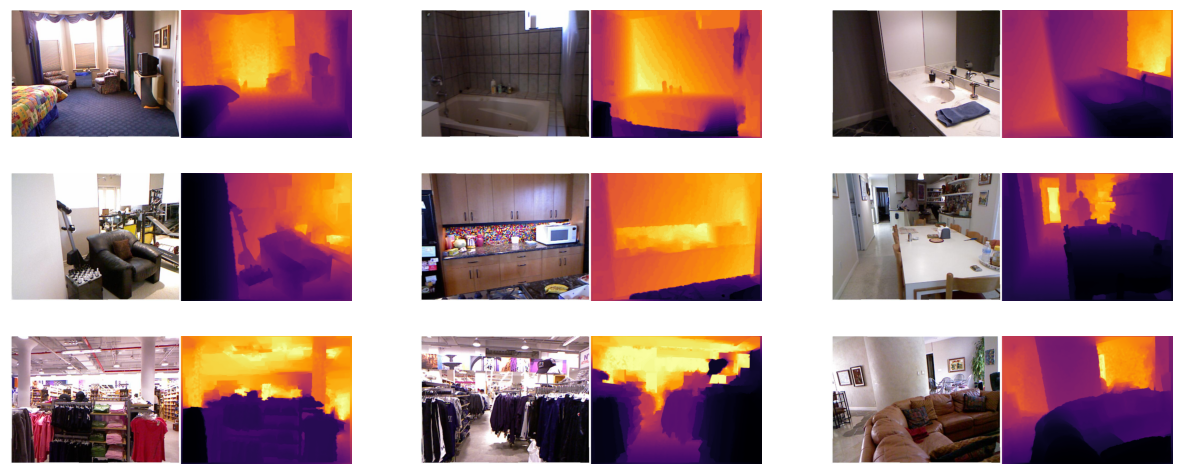

In [6]:
def colored_depthmap(depth, d_min=None, d_max=None,cmap=plt.cm.inferno):
    if d_min is None:
        d_min = np.min(depth)
    if d_max is None:
        d_max = np.max(depth)
    depth_relative = (depth - d_min) / (d_max - d_min)
    return 255 * cmap(depth_relative)[:,:,:3] # H, W, C

def merge_into_row(input, depth_target):
    input = np.array(input)
    depth_target = np.squeeze(np.array(depth_target))

    d_min = np.min(depth_target)
    d_max = np.max(depth_target)
    depth_target_col = colored_depthmap(depth_target, d_min, d_max)
    img_merge = np.hstack([input, depth_target_col])
    
    return img_merge

plt.figure(figsize=(15, 6))
for i, idx in enumerate(np.random.randint(0,len(df),(9,))):
    ax = plt.subplot(3, 3, i + 1)
    image = Image.open(df.iloc[idx,0]).convert('RGB')
    mask = Image.open(df.iloc[idx,1]).convert('L')
    image_viz = merge_into_row(
        image,mask
    )
    plt.imshow(image_viz.astype("uint8"))
    plt.axis("off")

In [7]:
sample_tfms = [
    A.HorizontalFlip(),
    A.GaussNoise(p=0.2),
    A.OneOf([
        A.MotionBlur(p=.3),
        A.MedianBlur(blur_limit=3, p=0.3),
        A.Blur(blur_limit=3, p=0.5),
    ], p=0.3),
    A.RGBShift(),
    A.RandomBrightnessContrast(),
    A.RandomResizedCrop(384,384),
    A.ColorJitter(),
    A.ShiftScaleRotate(shift_limit=0.1, scale_limit=0.3, rotate_limit=45, p=0.5),
    A.HueSaturationValue(p=0.3),
]
train_tfms = A.Compose([
    *sample_tfms,
    A.Resize(224,224),
    A.Normalize(always_apply=True),
    ToTensorV2()
])
valid_tfms = A.Compose([
    A.Resize(224,224),
    A.Normalize(always_apply=True),
    ToTensorV2()
])

In [8]:
class Dataset:
    def __init__(self,df,tfms):
        self.df = df
        self.tfms=tfms
    def open_im(self,p,gray=False):
        im = cv.imread(str(p))
        im = cv.cvtColor(im,cv.COLOR_BGR2GRAY if gray else cv.COLOR_BGR2RGB)
        return im
    
    def __len__(self,):
        return len(self.df)
    
    def __getitem__(self,idx):
        s = self.df.iloc[idx,:]
        im, dp = s[0],s[1]
        im, dp = self.open_im(im), self.open_im(dp,True)
        augs = self.tfms(image=im,mask=dp)
        im, dp = augs['image'], augs['mask'] / 255.
        return im, dp.unsqueeze(0)

In [9]:
train_ds = Dataset(train_df,train_tfms)
val_ds = Dataset(val_df,valid_tfms)
test_ds = Dataset(test_df, valid_tfms)
len(train_ds), len(val_ds), len(test_ds)

(45619, 4562, 507)

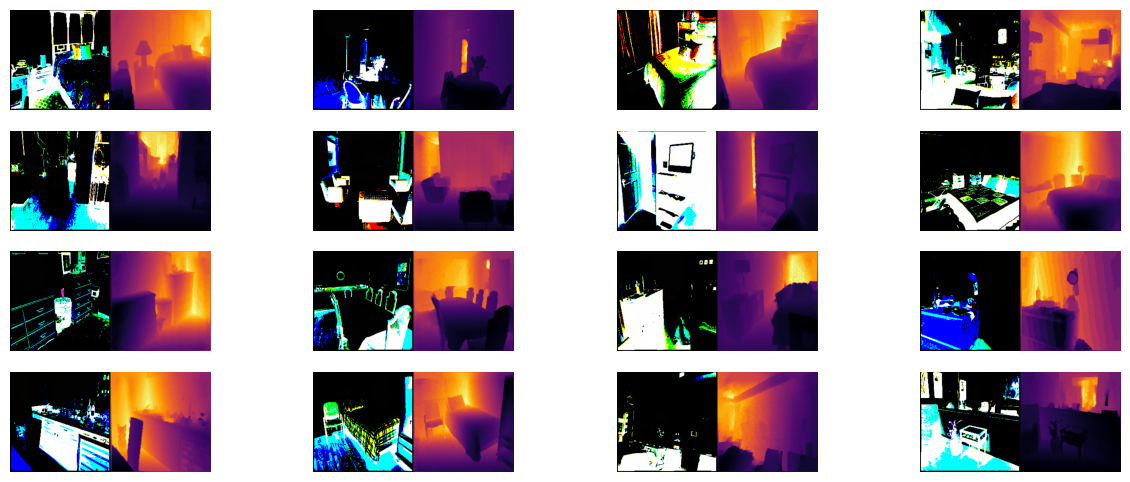

In [10]:
randoms = [test_ds[idx] for idx in range(16)]
plt.figure(figsize=(15, 6))
for i, (img,mask) in enumerate(randoms):
    ax = plt.subplot(4, 4, i + 1)
    img, mask = img.permute(1,2,0).numpy(), mask.permute(1,2,0).numpy()
    mask = colored_depthmap(np.squeeze(mask))
    image_viz = np.hstack([img,mask])
    plt.imshow(image_viz.astype("uint8"))
    plt.axis("off")

In [11]:
train_dl = torch.utils.data.DataLoader(train_ds,shuffle=True,batch_size=64)
val_dl = torch.utils.data.DataLoader(val_ds,shuffle=False,batch_size=64)
test_dl = torch.utils.data.DataLoader(test_ds, shuffle=True, batch_size=4)
len(train_dl), len(val_dl), len(test_dl)

(713, 72, 127)

In [17]:
import segmentation_models_pytorch as smp

# Khởi tạo mô hình U++
model = smp.UnetPlusPlus(
    encoder_name='resnext50_32x4d',        # Backbone encoder
    encoder_weights="imagenet",    # Pretrained weights
    in_channels=3,                 # Số kênh đầu vào (3 cho ảnh RGB)
    classes=1                      # Số kênh đầu ra (1 cho depth map)
)

# Xem thông tin mô hình
print(model)


UnetPlusPlus(
  (encoder): ResNetEncoder(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
        (bn2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(128, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downsa

In [25]:
class UNet(nn.Module):
    def __init__(self,):
        super().__init__()
        self.model = smp.UnetPlusPlus(
            encoder_name='resnet50',
            encoder_weights="imagenet",
            in_channels=3,
            classes=1
        )
        
    def trainable_encoder(self,trainable=True):
        for p in self.model.encoder.parameters():
            p.requires_grad = trainable
        
    def forward(self,x):
        return self.model(x)
    
    def _num_params(self,):
        return sum([p.numel() for p in self.model.parameters() if p.requires_grad])

In [26]:
class UnNormalize(Normalize):
    def __init__(self,*args,**kwargs):
        mean=(0.485, 0.456, 0.406)
        std=(0.229, 0.224, 0.225)
        new_mean = [-m/s for m,s in zip(mean,std)]
        new_std = [1/s for s in std]
        super().__init__(new_mean, new_std, *args, **kwargs)

@torch.no_grad()
def plot_vals(imgs, preds, targets,n=4,figsize=(6,2),title=''):
    plt.figure(figsize=figsize,dpi=150)
    r = 2 if n == 4 else 8
    c = 2
    for i,idx in enumerate(np.random.randint(0,imgs.size(0),(n,))):
        ax = plt.subplot(r,c,i + 1)
        img,pred,gt = imgs[idx], preds[idx], targets[idx]
        img = UnNormalize()(img)*255.
        img,pred,gt = img.permute(1,2,0).numpy(), pred.permute(1,2,0).numpy(), gt.permute(1,2,0).numpy()
        pred = colored_depthmap(np.squeeze(pred))
        gt = colored_depthmap(np.squeeze(gt))
        image_viz = np.hstack([img,pred,gt])
        plt.imshow(image_viz.astype("uint8"))
        plt.axis("off")
    title = f'{title}\nimage/target/prediction' if len(title)!=0 else 'image/target/prediction'
    plt.suptitle(title)
    plt.show()

In [27]:
epochs = 7
freeze_epochs = 2
lr = 1e-3

device = 'cuda'

metrics = MetricCollection([
    SSIM(data_range=(0,1)),
    MSE()
]).to(device)
train_metrics = metrics.clone()
val_metrics = metrics.clone()

logs = pd.DataFrame()
logs[['loss_train','loss_val','ssim_train','ssim_val','mse_train','mse_val']]=None

model = UNet().to(device)
model.trainable_encoder(trainable=False)

loss_fn = nn.MSELoss()
optim = torch.optim.AdamW(model.parameters(),lr=lr / 25.,weight_decay=0.02)
sched = torch.optim.lr_scheduler.OneCycleLR(optim,max_lr=lr,epochs=epochs,steps_per_epoch=(len(train_dl)))

scaler = GradScaler()

/tmp/ipykernel_23/1437596528.py:24: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler()


  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/713 [00:00<?, ?it/s]

/tmp/ipykernel_23/2865621306.py:18: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


  0%|          | 0/72 [00:00<?, ?it/s]

/tmp/ipykernel_23/2865621306.py:51: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():




  loss_train  loss_val ssim_train  ssim_val mse_train   mse_val
0   0.051393  0.008588   0.499643  0.713836  0.051403  0.008554




/tmp/ipykernel_23/2865621306.py:76: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


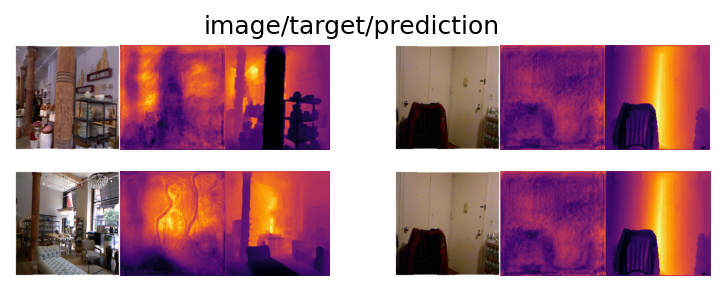

  0%|          | 0/713 [00:00<?, ?it/s]

/tmp/ipykernel_23/2865621306.py:18: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


  0%|          | 0/72 [00:00<?, ?it/s]

/tmp/ipykernel_23/2865621306.py:51: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():




  loss_train  loss_val ssim_train  ssim_val mse_train   mse_val
1    0.01129  0.006285   0.807554  0.815757  0.011289  0.006274




/tmp/ipykernel_23/2865621306.py:76: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


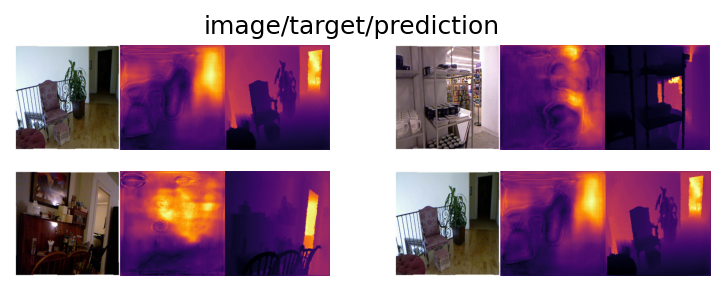

training encoder and decoder both


  0%|          | 0/713 [00:00<?, ?it/s]

/tmp/ipykernel_23/2865621306.py:18: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


  0%|          | 0/72 [00:00<?, ?it/s]

/tmp/ipykernel_23/2865621306.py:51: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():




  loss_train  loss_val ssim_train ssim_val mse_train mse_val
2   0.013532  0.014383   0.831249  0.83249  0.013533  0.0143




/tmp/ipykernel_23/2865621306.py:76: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


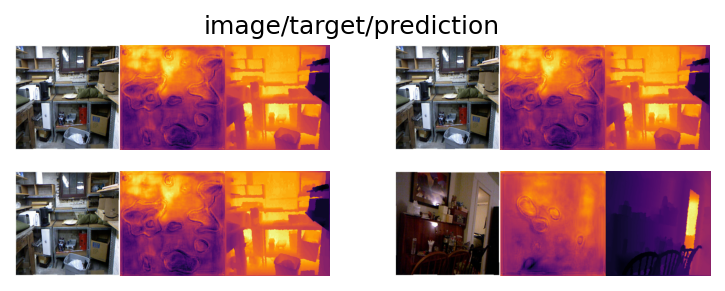

  0%|          | 0/713 [00:00<?, ?it/s]

/tmp/ipykernel_23/2865621306.py:18: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


  0%|          | 0/72 [00:00<?, ?it/s]

/tmp/ipykernel_23/2865621306.py:51: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():




  loss_train  loss_val ssim_train  ssim_val mse_train   mse_val
3   0.010049  0.006433   0.860216  0.873008   0.01005  0.006402




/tmp/ipykernel_23/2865621306.py:76: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


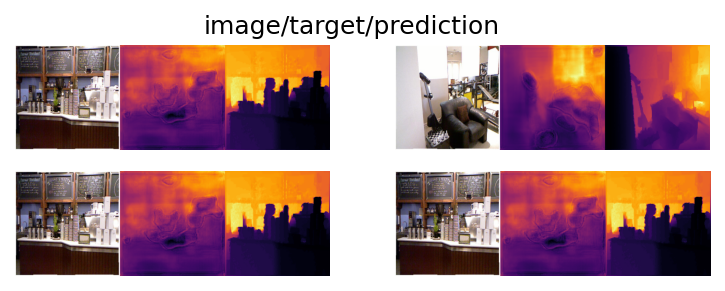

  0%|          | 0/713 [00:00<?, ?it/s]

/tmp/ipykernel_23/2865621306.py:18: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


  0%|          | 0/72 [00:00<?, ?it/s]

/tmp/ipykernel_23/2865621306.py:51: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():




  loss_train  loss_val ssim_train  ssim_val mse_train  mse_val
4   0.008095  0.003949   0.874789  0.885495  0.008096  0.00394




/tmp/ipykernel_23/2865621306.py:76: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


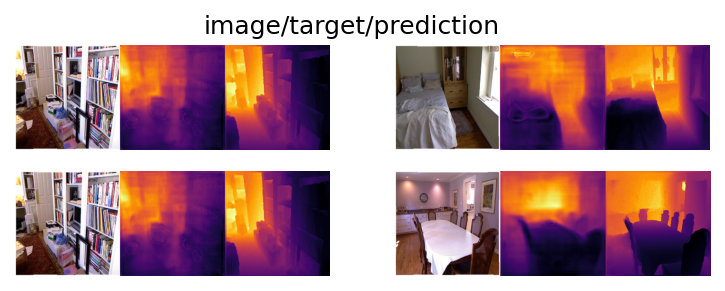

  0%|          | 0/713 [00:00<?, ?it/s]

/tmp/ipykernel_23/2865621306.py:18: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


  0%|          | 0/72 [00:00<?, ?it/s]

/tmp/ipykernel_23/2865621306.py:51: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():




  loss_train  loss_val ssim_train  ssim_val mse_train   mse_val
5   0.006363  0.003357   0.885126  0.892872  0.006363  0.003347




/tmp/ipykernel_23/2865621306.py:76: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


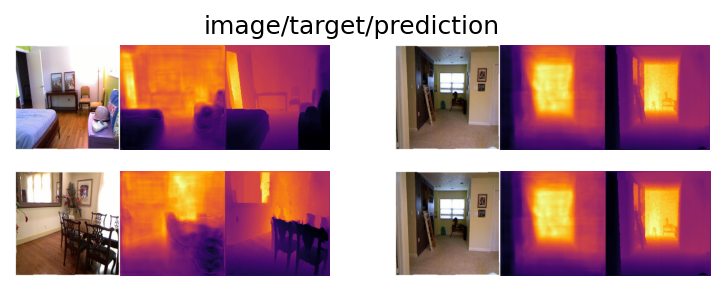

  0%|          | 0/713 [00:00<?, ?it/s]

/tmp/ipykernel_23/2865621306.py:18: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


  0%|          | 0/72 [00:00<?, ?it/s]

/tmp/ipykernel_23/2865621306.py:51: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():




  loss_train  loss_val ssim_train  ssim_val mse_train   mse_val
6   0.005488  0.003127   0.890268  0.893422  0.005488  0.003117




/tmp/ipykernel_23/2865621306.py:76: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


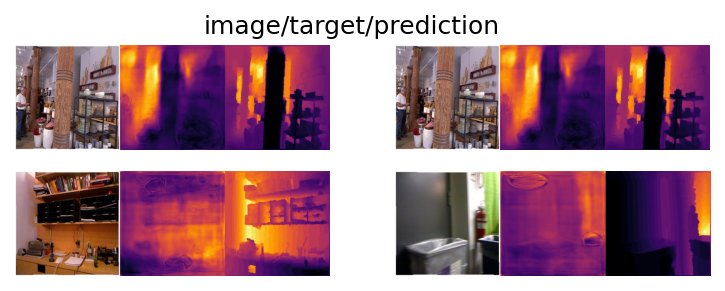

In [28]:
best_ssim = -1e9
best_epoch = -1


for epoch in tqdm(range(epochs)):
    
    model.train()
    
    if epoch == freeze_epochs:
        model.trainable_encoder(trainable=True)
        print('training encoder and decoder both')
    
    running_loss = 0.
    train_prog = tqdm(train_dl,total=len(train_dl))
    
    for img, mask in train_prog:
        
        with autocast():
            img, mask = img.to(device), mask.to(device)
            preds = model(img)

            loss = loss_fn(preds,mask)
            scaler.scale(loss).backward()
            scaler.unscale_(optim)
            nn.utils.clip_grad_norm_(model.parameters(), max_norm=2.0, norm_type=2)
            scaler.step(optim)
            scaler.update()
            sched.step()
            optim.zero_grad()

            running_loss += loss.item()

            train_prog.set_description(f'loss: {loss.item():.3f}')
            train_metrics(preds,mask)
        
        del img, mask, preds, loss

    m = train_metrics.compute()
    _ssim,_mse = m['StructuralSimilarityIndexMeasure'].cpu().item(), m['MeanSquaredError'].cpu().item()
    logs.loc[epoch,['loss_train','ssim_train','mse_train']] = (running_loss/len(train_dl),_ssim,_mse)
    train_metrics.reset()
    model.eval()
    
    with torch.no_grad():
        
        running_loss = 0.
        
        val_prog = tqdm(val_dl,total=len(val_dl))
        for img, mask in val_prog:

            with autocast():
                img, mask = img.to(device), mask.to(device)
                preds = model(img)
                loss = loss_fn(preds,mask)
                running_loss += loss.item()
                val_prog.set_description(f'loss: {loss.item():.3f}')
                
                val_metrics(preds, mask)
                
            del img, mask, preds, loss
            
        m = val_metrics.compute()
        _ssim,_mse = m['StructuralSimilarityIndexMeasure'].cpu().item(), m['MeanSquaredError'].cpu().item()
        logs.loc[epoch,['loss_val','ssim_val','mse_val']] = (running_loss/len(val_dl),_ssim,_mse)
        val_metrics.reset()
    
    if _ssim > best_ssim:
        best_ssim = _ssim
        best_epoch = epoch
        sd = model.state_dict()
        torch.save(sd,'/kaggle/working/U++.pt')
        
    print(f"\n\n{logs.tail(1)}\n\n")
    
    with torch.no_grad():
        with autocast():
            img, mask = next(iter(test_dl))
            img, mask = img.to(device), mask.to(device)
            preds = model(img)
            plot_vals(
                img.cpu(),
                preds.cpu(),
                mask.cpu()
            )
        
    gc.collect()
    torch.cuda.empty_cache()

In [29]:
best_epoch

6

In [30]:
best_sd = torch.load('/kaggle/working/U++.pt')
model.load_state_dict(best_sd)

/tmp/ipykernel_23/3295671200.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  best_sd = torch.load('/kaggle/working/U++.pt')


<All keys matched successfully>

/tmp/ipykernel_23/3490609406.py:3: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


  0%|          | 0/127 [00:00<?, ?it/s]

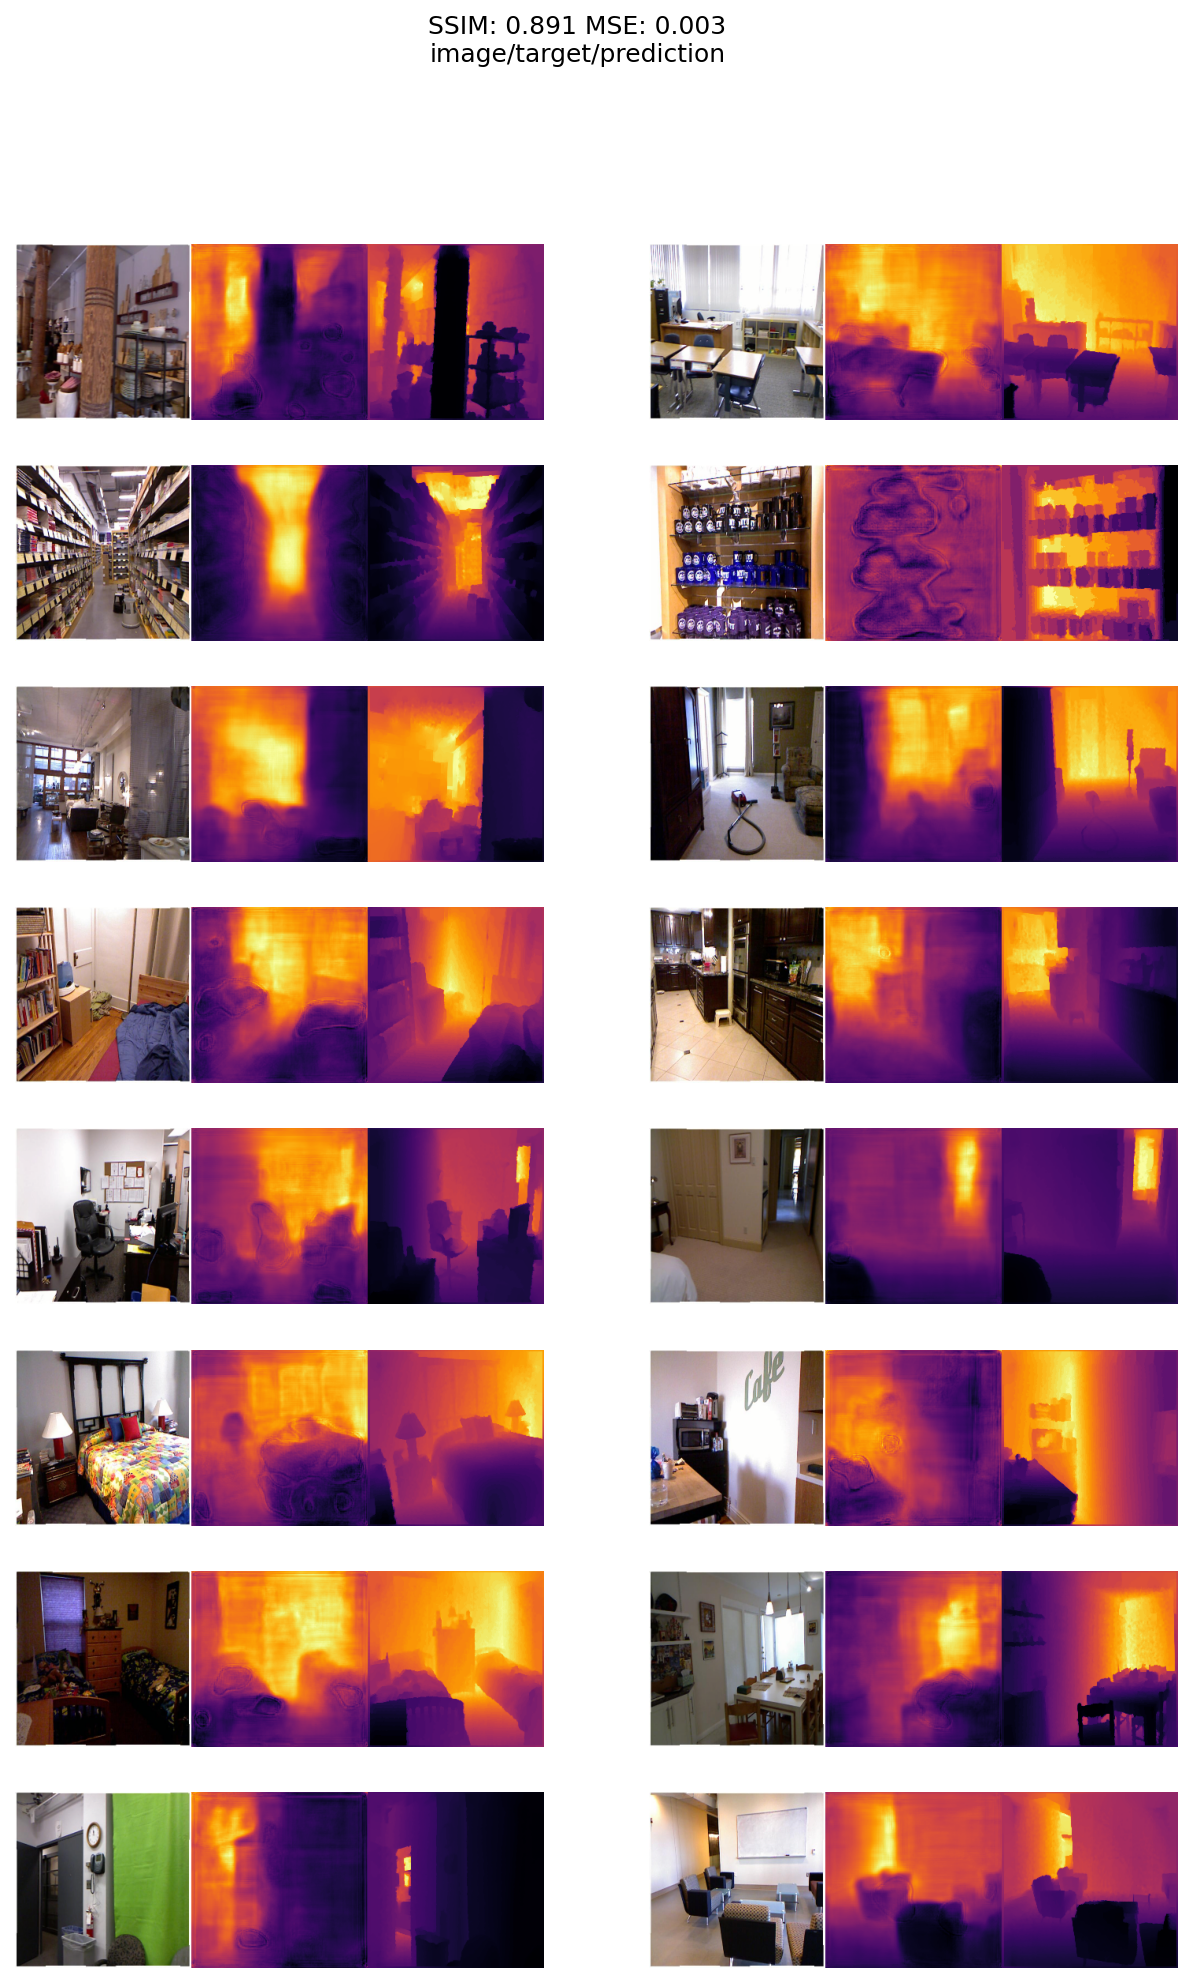

In [ ]:
all_imgs, all_preds, all_targets = [], [], []
with torch.no_grad():
    with autocast():
        for img, mask in tqdm(test_dl,total=len(test_dl)):
            img, mask = img.to(device), mask.to(device)
            preds = model(img)
            all_imgs.append(img)
            all_preds.append(preds)
            all_targets.append(mask)
test_metrics = metrics.clone()
test_metrics(
    torch.vstack(all_preds),
    torch.vstack(all_targets)
)
m = test_metrics.compute()
title = f"SSIM: {m['StructuralSimilarityIndexMeasure'].cpu().item():.3f} MSE: {m['MeanSquaredError'].cpu().item():.3f}"
plot_vals(
    torch.vstack(all_imgs).cpu(),
    torch.vstack(all_preds).cpu(),
    torch.vstack(all_targets).cpu(),
    n=16,
    figsize=(10,15),
    title=title
)

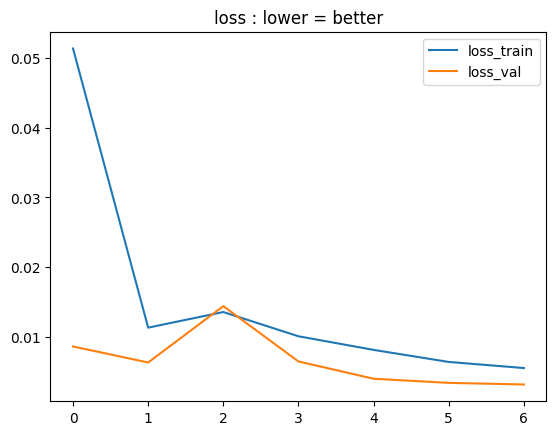

In [32]:
logs['loss_train'].plot()
logs['loss_val'].plot()
plt.title('loss : lower = better')
plt.legend()
plt.show()

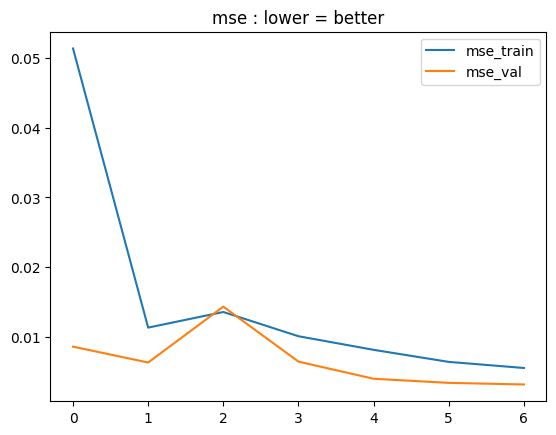

In [33]:
logs['mse_train'].plot()
logs['mse_val'].plot()
plt.title('mse : lower = better')
plt.legend()
plt.show()

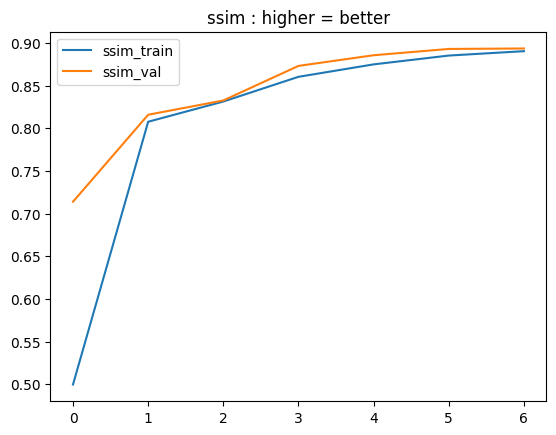

In [34]:
logs['ssim_train'].plot()
logs['ssim_val'].plot()
plt.title('ssim : higher = better')
plt.legend()
plt.show()